In [1]:
import warnings; warnings.simplefilter('ignore')

import random
import os
import time
import itertools
import collections
import scipy as sp
import pandas as pd
from cell import graph_utils, utils, math_utils, analysis, plot_utils
from stellargraph import StellarDiGraph
import cell.BiasedDirectedWeightedWalk as BDWW
from mpl_toolkits import mplot3d
import seaborn as sns

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
connectome_filename = "SI_5_Connectome_adjacency_matrices_corrected_July2020.xlsx"
cell_list_filename = "SI_4_Cell_lists.xlsx"
path = "/Users/fahimehb/Documents/C-elegance/dat/Connectomes/"

In [3]:
pharynx = pd.read_excel(path + cell_list_filename, sheet_name="pharynx", index_col="Unnamed: 0")
pharynx_shared_neurons = pharynx[pharynx["cell type"].isin(["interneuron", "motorneuron"])].index.tolist()

sex = pd.read_excel(path + cell_list_filename, sheet_name="sex-shared", index_col="Unnamed: 0")
sex_shared_neurons = sex[sex["cell type"].isin(["interneuron", "motorneuron", "sensory", "neuron"])].index.tolist()

hermaphrodite_specific = pd.read_excel(path + cell_list_filename, sheet_name="hermaphrodite specific", index_col="Unnamed: 0")
hermaphrodite_specific_neurons = hermaphrodite_specific[hermaphrodite_specific["cell type"].isin(["motorneuron"])].index.tolist()
herm_neurons = sex_shared_neurons + pharynx_shared_neurons + hermaphrodite_specific_neurons 

male_specific = pd.read_excel(path + cell_list_filename, sheet_name="male-specific", index_col="name")
male_specific_neurons = male_specific[male_specific["cell type"].isin(["interneuron", "sensory neuron"])].index.tolist()
male_neurons = sex_shared_neurons + pharynx_shared_neurons + male_specific_neurons 

In [4]:
print("Number of herm neurons")
print(len(herm_neurons))


print("Number of herm neurons")
print(len(male_neurons))


Number of herm neurons
302
Number of herm neurons
385


In [5]:
cldf_herm = pd.read_excel(path + connectome_filename, sheet_name="anno_hermaphrodite_chem")
cldf_herm.cluster_id = cldf_herm.cluster_id.astype('str')
cldf_herm.class_id = cldf_herm.class_id.astype('str')
cldf_herm.subclass_id = cldf_herm.subclass_id.astype('str')
cldf_herm["herm_neuron"] = np.nan
cldf_herm["male_neuron"] = np.nan
cldf_herm.loc[cldf_herm["cluster_label"].isin(herm_neurons), "herm_neuron"] =True
cldf_herm.loc[cldf_herm["cluster_label"].isin(male_neurons), "male_neuron"] =True

In [6]:
cldf_herm.shape

(473, 12)

In [7]:
herm_neurons = cldf_herm[cldf_herm["herm_neuron"]==True]["cluster_label"].tolist()
male_neurons = cldf_herm[cldf_herm["male_neuron"]==True]["cluster_label"].tolist()

In [8]:
herm_neurons.remove('CANL')
herm_neurons.remove('CANR')

In [9]:
len(herm_neurons)

300

# Read Chem and gap junction and add them for herm

Open the following cell if you need to see the codes

In [10]:
herm_chem = pd.read_excel(path + connectome_filename, sheet_name="hermaphrodite chemical", 
                          header=2, index_col="Unnamed: 2", nrows=300)
herm_gj = pd.read_excel(path + connectome_filename, sheet_name="hermaphrodite gap jn symmetric", 
                        header=2, index_col="Unnamed: 2", nrows=469)

herm_chem = herm_chem.drop(labels=["Unnamed: 0", "Unnamed: 1", "Unnamed: 457"], axis=1)
herm_gj = herm_gj.drop(labels=["Unnamed: 0", "Unnamed: 1", "Unnamed: 472"], axis=1)

herm_chem = herm_chem.fillna(0)
herm_gj = herm_gj.fillna(0)

#Making chem square matrix
#herm_chem_index = herm_chem.index.tolist()
#missing_index = [i for i in herm_chem.columns.tolist() if i not in herm_chem_index]
#missing_df = pd.DataFrame(0, index=missing_index, columns=herm_chem.columns.tolist())
#herm_chem = pd.concat((herm_chem, missing_df))
#herm_chem = herm_chem.loc[herm_chem.columns.tolist()][herm_chem.columns.tolist()]
herm_chem = herm_chem.loc[herm_neurons][herm_neurons]
herm_gj = herm_gj.loc[herm_neurons][herm_neurons]

# #Check which cells are missing in each matrix
# herm_chem_cells = herm_chem.index.tolist()
# herm_gj_cells = herm_gj.index.tolist()
# cells_toadd_to_gj = [i for i in herm_chem_cells if i not in herm_gj_cells]
# cells_toadd_to_chem = [i for i in herm_gj_cells if i not in herm_chem_cells]

# #Add missing rows to each matrix
# missing_df = pd.DataFrame(0, index=cells_toadd_to_gj, columns=herm_gj.columns.tolist())
# herm_gj = pd.concat((herm_gj, missing_df))
# missing_df = pd.DataFrame(0, index=cells_toadd_to_chem, columns=herm_chem.columns.tolist())
# herm_chem = pd.concat((herm_chem, missing_df))

# #Add missing columns to each matrix
# for cell in cells_toadd_to_gj:
#     herm_gj[cell] = np.nan
# for cell in cells_toadd_to_chem:
#     herm_chem[cell] = np.nan
    
# print(herm_chem.shape)
# print(herm_gj.shape)

# #Put both matrix to the same order
# herm_chem = herm_chem.loc[herm_gj.index.tolist()][herm_gj.columns.tolist()]

# herm_chem = herm_chem.fillna(0)
# herm_gj = herm_gj.fillna(0)

# #Threshold
# herm_chem[herm_chem>30]=30
# herm_gj[herm_gj>30]=30

# # Add the two matrices 

connectome = herm_chem.add(herm_gj)
index_column_names = connectome.index.copy()
connectome = connectome.loc[index_column_names][index_column_names]
connectome = connectome.reset_index().rename(columns={"index": "cluster_label"}, errors="raise")
connectome = connectome.merge(cldf_herm[["cluster_label", "cluster_id"]], on="cluster_label")
connectome = connectome.set_index("cluster_id")
connectome = connectome.drop(columns="cluster_label")
connectome = connectome[index_column_names]
connectome.columns = connectome.index
connectome.columns.name = None

In [12]:
# %matplotlib qt5
# sns.heatmap(connectome)

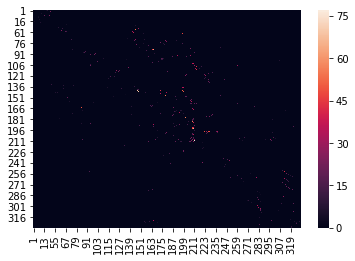

In [12]:
percentile = 0.3
connectome_masked = graph_utils.keep_k_percentile_of_each_col_and_each_row(connectome, percentile)
sns.heatmap(connectome_masked)

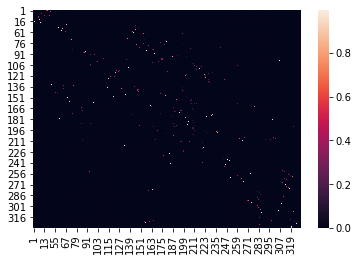

In [23]:
#%matplotlib qt5
# plt.figure(figsize=(20,15))
connectome_double_stochastic = graph_utils.apply_doubly_stochastic(connectome_masked)
sns.heatmap(connectome_double_stochastic)

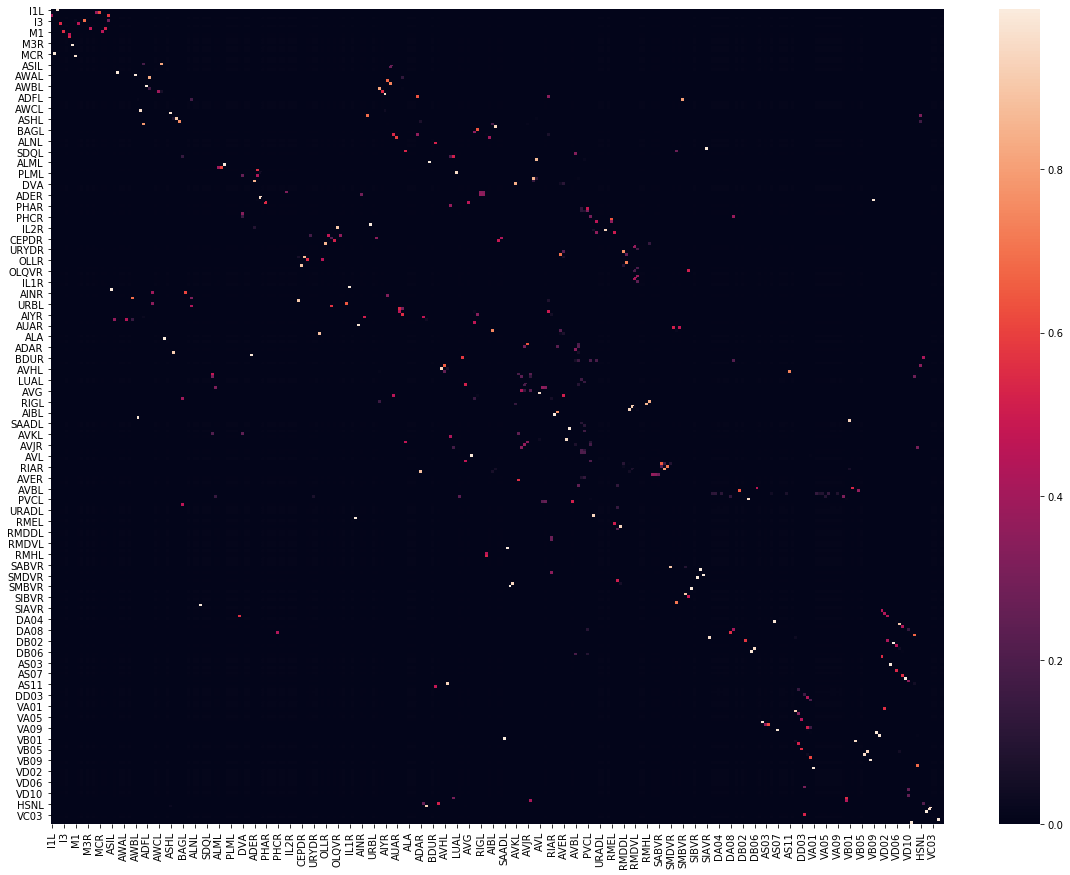

In [20]:
fig = plt.figure(figsize=(30,23))
sns.heatmap(tmp)
fig.savefig("/Users/fahimehb/Documents/NPP_GNN_project/dat/fig/double_stochastic_c_elegance.pdf")

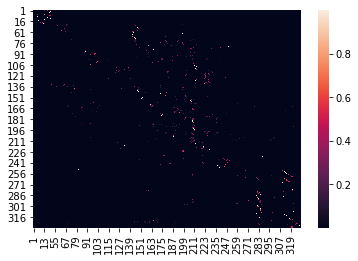

In [17]:
percentile = 0.5
connectome_masked = graph_utils.keep_k_percentile_of_each_row(connectome, percentile)
# sns.heatmap(connectome_masked)
# plt.figure(figsize=(20,15))
connectome_masked = connectome_masked + 0.00001
connectome_row_normalized = graph_utils.Divide_each_Row_by_colsum(connectome_masked)
sns.heatmap(connectome_row_normalized)

In [24]:
# connectome_double_stochastic.to_csv("/Users/fahimehb/Documents/C-elegance/dat/Connectomes/herm_chem_gj_neuron_only_double_stochastic_no_threshold_50p_dynamic_nn.csv")

In [303]:
# connectome_row_normalized.to_csv("/Users/fahimehb/Documents/C-elegance/dat/Connectomes/herm_chem_gj_neuron_only_row_normalized_no_threshold_30p_dynamic_nn.csv")

In [18]:
# edges = graph_utils.build_edge_list(weight_matrix=connectome_row_normalized, threshold=None, directed=True)
# nxg = graph_utils.build_nx_graph(source_target_weight=edges, directed=True)

# # 2) Create stellar Di graphs
# sdg = StellarDiGraph(nxg)
# BDWW.BeginWalk(sdg, begin_checks=True, weighted=True, directed=True)
# rw = BDWW.BiasedDirectedRandomWalk(sdg, directed=True, weighted=True, begin_checks=False)

# nodes = list(sdg.nodes())
# walks = rw.run(nodes=nodes, length=100, n=100, p=1, q=1, weighted=True, directed=True)

# utils.write_list_of_lists_to_csv(path + "/walk_herm_chem_gj_neuron_only_row_normalized_no_threshold_50p_dynamic_nn.csv", walks)

In [28]:
prefix = "celegance_run7"
finished_epoch = 2900 + 100
nandcg_E = []
nandcg_R = []
for e in range(0, finished_epoch, 100):
    epoch = e
    n_emb = 5

    E = pd.read_csv("/Users/fahimehb/Documents/C-elegance/dat/run_results/" + 
                    prefix + "_" + str(epoch) + "_E_w1_" + str(n_emb) + "d.csv", index_col="Unnamed: 0")
    R = pd.read_csv("/Users/fahimehb/Documents/C-elegance/dat/run_results/" + 
                    prefix + "_" + str(epoch) + "_R_w1_" + str(n_emb) + "d.csv", index_col="Unnamed: 0")

    E.index = E.index.astype(str)
    R.index = R.index.astype(str)

    E_to_R_dist = analysis.get_distance_between_eachrow_of_one_df_with_all_rows_of_other_df(E[["Z" + str(i) for i in range(n_emb)]], 
                                                                                            R[["Z" + str(i) for i in range(n_emb)]])
    nandcg_E.append(analysis.Compute_node_average_ndcg(adj=connectome_double_stochastic, e_to_r=E_to_R_dist, k=3))   
    nandcg_R.append(analysis.Compute_node_average_ndcg(adj=connectome_double_stochastic.T, e_to_r=E_to_R_dist.T, k=3))   

In [41]:
fig = plt.figure(figsize=(15,8))
plt.scatter([i for i in range(0, finished_epoch, 100)],nandcg_E, color='blue')
plt.plot([i for i in range(0, finished_epoch, 100)], nandcg_E, color='blue', label='nandcg_E')
plt.scatter([i for i in range(0, finished_epoch, 100)],nandcg_R, color='red')
plt.plot([i for i in range(0, finished_epoch, 100)], nandcg_R, color='red', label='nandcg_R')
plt.xlabel("epochs")
plt.ylabel("nandcg@3")
plt.legend()
fig.savefig("/Users/fahimehb/Documents/NPP_GNN_project/dat/fig/C-eleganse_nandcg.pdf")


In [30]:
%matplotlib qt5
fig=plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(E['Z0'], E['Z1'], E["Z2"])
ax.scatter(R['Z0'], R['Z1'], R["Z2"], c="red")

In [32]:
E.index.name = "cluster_id"
R.index.name = "cluster_id"
E = E.merge(cldf_herm, on='cluster_id')
R = R.merge(cldf_herm, on='cluster_id')
E = E.set_index("cluster_id")
R = R.set_index("cluster_id")

In [33]:
E["node_act"] = "E"
R['node_act'] = "R"

In [197]:
# E_to_R_dist.index.name = "cluster_label"
# new_index = E_to_R_dist.merge(cldf_herm.reset_index(), on="cluster_label")["cluster_id"].tolist()
# E_to_R_dist.index = new_index
# E_to_R_dist.columns = new_index

In [207]:
# connectome_double_stochastic.index.name = "cluster_label"
# new_index = connectome_double_stochastic.merge(cldf_herm.reset_index(), on="cluster_label")["cluster_id"].tolist()
# connectome_double_stochastic.index = new_index
# connectome_double_stochastic.columns = new_index

In [34]:
tmp, _ = plot_utils.plot_node_average_ndcg(adj=connectome_double_stochastic, e_to_r=E_to_R_dist, k=3, figsize=(25,5))
# tmp1, _ = plot_utils.plot_node_average_ndcg(adj=connectome_masked, e_to_r=E_to_R_dist, k=3, figsize=(25,5))

In [263]:
plot_utils.plot_multiple_dict({"Double_stochastic":tmp, "Original":tmp1})

In [35]:
emb_umap = analysis.Compute_umap(pd.concat((E, R)), 5)
em = emb_umap[emb_umap['node_act']=="E"]
em = em.set_index('cluster_id')

re = emb_umap[emb_umap['node_act']=="R"]
re = re.set_index('cluster_id')

In [40]:

fig = plot_utils.plot_ER(emitter=em, 
                   receiver=re, 
                   figsize=(12,5), 
                   plot_dim=2, 
                   annotation=False, 
                   annotation_label="cluster_label",
                   E_marker='o', 
                   R_marker='x', 
                   resolution="cluster_label",
                   side_by_side=True,
#                    E_sublist_to_color=em[em['cluster_label']=="ADEL"],
#                    R_sublist_to_color=re[re['cluster_label'].isin(["RIGL", "RIGR", "IL2L"])]
                        )

In [41]:
node_act = 'E'
node_id = '187'#150
node_label = None
analysis.get_closest_nodes_info(node_label=node_label, 
                                node_id=node_id,
                                E_to_R_dist=E_to_R_dist, 
                                adjacency=connectome_double_stochastic, 
                                topn=7, 
                                cldf=cldf_herm, 
                                resolution="cluster_label", 
                                node_action=node_act)


Closet neighbors of cluster_label AVKL
______________________________________


,predicted_neighbors_weights,predicted_closest_neighbors_index,predicted_closest_neighbors_label,Actual_neighbor_weights,Actual_neighbor_index,Actual_neighbor_label,match
0,0.2444,188,AVKR,0.2444,188,AVKR,1
1,0.0000,165,PVPL,0.2443,95,DVA,1
2,0.0000,75,BAGL,0.2116,85,AQR,0
3,0.2443,95,DVA,0.0028,6,I4,0
4,0.0007,65,AFDL,0.0028,6,I4,0
5,0.0000,166,PVPR,0.0028,6,I4,0
6,0.0000,100,PDEL,0.0028,6,I4,0


In [42]:
node_act = 'R'
node_label = None
analysis.get_closest_nodes_info(node_label=node_label, 
                                node_id=node_id,
                                E_to_R_dist=E_to_R_dist, 
                                adjacency=connectome_double_stochastic, 
                                topn=3, 
                                cldf=cldf_herm, 
                                resolution="cluster_label", 
                                node_action=node_act)


Closet neighbors of cluster_label AVKL
______________________________________


,predicted_neighbors_weights,predicted_closest_neighbors_index,predicted_closest_neighbors_label,Actual_neighbor_weights,Actual_neighbor_index,Actual_neighbor_label,match
0,0.8389,95,DVA,0.8389,95,DVA,1
1,0.0000,201,RIMR,0.1427,176,RIGR,0
2,0.0000,125,OLQDR,0.0002,4,I2R,0


In [159]:
cldf_herm[cldf_herm.class_label == "SENSORY NEURONS"]["cluster_id"].tolist()[10:20]

['61', '62', '63', '64', '65', '66', '67', '68', '69', '70']

In [162]:
cldf_herm[cldf_herm.cluster_label.isin(["AIMR", "HSNL"])]

,cluster_id,cluster_label,cluster_color,subclass_label,subclass_id,subclass_color,class_id,class_label,class_color,herm_neuron,male_neuron
136,137,AIMR,#A1BFFF,INTERNEURONS 4,8,#A1BFFF,3.0,INTERNEURONS,#A1BFFF,True,True
438,439,HSNL,#DC27F2,SEX-SPECIFIC CELLS 1,17,#DC27F2,7.0,SEX-SPECIFIC CELLS,#DC27F2,True,NaN


In [76]:
np.unique(cldf_herm[cldf_herm.herm_neuron==True]["subclass_label"])

array(['BODY MOTOR NEURONS', 'HEAD MOTOR NEURONS', 'INTERNEURONS 1',
       'INTERNEURONS 2', 'INTERNEURONS 3', 'INTERNEURONS 4',
       'OTHER END ORGANS 1', 'PHARYNX', 'SENSORY NEURONS 1',
       'SENSORY NEURONS 2', 'SENSORY NEURONS 3', 'SENSORY NEURONS 4',
       'SENSORY NEURONS 5', 'SENSORY NEURONS 6', 'SEX-SPECIFIC CELLS 1',
       'SUBLATERAL MOTOR NEURONS'], dtype=object)

In [40]:
cldf_herm[cldf_herm.cluster_label == "AVKL"]

,cluster_id,cluster_label,cluster_color,subclass_label,subclass_id,subclass_color,class_id,class_label,class_color,herm_neuron,male_neuron
186,187,AVKL,#0000FF,INTERNEURONS 2,10,#0000FF,3.0,INTERNEURONS,#A1BFFF,True,True


In [43]:
cldf_herm[cldf_herm.cluster_id.isin(["188", "165", "95"])]

,cluster_id,cluster_label,cluster_color,subclass_label,subclass_id,subclass_color,class_id,class_label,class_color,herm_neuron,male_neuron
94,95,DVA,#EC2D46,SENSORY NEURONS 3,5,#EC2D46,2.0,SENSORY NEURONS,#C60C0F,True,True
164,165,PVPL,#9A85EC,INTERNEURONS 3,9,#9A85EC,3.0,INTERNEURONS,#A1BFFF,True,True
187,188,AVKR,#0000FF,INTERNEURONS 2,10,#0000FF,3.0,INTERNEURONS,#A1BFFF,True,True
